# Flu Shot Prediction

In [74]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import shap
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data = pd.read_csv('training_set_features.csv')
label = pd.read_csv('training_set_labels.csv')
test_data = pd.read_csv('test_set_features.csv')

In [3]:
train_data = train_data.drop(columns=['respondent_id'])
test_data = test_data.drop(columns=['respondent_id'])

In [4]:
numerical = train_data.select_dtypes('number').columns

categorical = ['race', 'sex', 'marital_status', 'rent_or_own', 'hhs_geo_region',
               'census_msa', 'employment_industry', 'employment_occupation']

ordinal = ['age_group', 'education', 'income_poverty', 'employment_status']

## Imputing Values

In [5]:
(train_data.isna().sum() / len(train_data)) * 100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
health_insurance               45.957989
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex             

In [6]:
for col in (categorical + ordinal):
    train_data[col] = train_data[col].fillna(value='NA')
    test_data[col] = test_data[col].fillna(value='NA')

for n in numerical:
    train_data[n] = train_data[n].fillna(value=-1)
    test_data[n] = test_data[n].fillna(value=-1)

In [7]:
(train_data.isna().sum() / len(train_data)) * 100

h1n1_concern                   0.0
h1n1_knowledge                 0.0
behavioral_antiviral_meds      0.0
behavioral_avoidance           0.0
behavioral_face_mask           0.0
behavioral_wash_hands          0.0
behavioral_large_gatherings    0.0
behavioral_outside_home        0.0
behavioral_touch_face          0.0
doctor_recc_h1n1               0.0
doctor_recc_seasonal           0.0
chronic_med_condition          0.0
child_under_6_months           0.0
health_worker                  0.0
health_insurance               0.0
opinion_h1n1_vacc_effective    0.0
opinion_h1n1_risk              0.0
opinion_h1n1_sick_from_vacc    0.0
opinion_seas_vacc_effective    0.0
opinion_seas_risk              0.0
opinion_seas_sick_from_vacc    0.0
age_group                      0.0
education                      0.0
race                           0.0
sex                            0.0
income_poverty                 0.0
marital_status                 0.0
rent_or_own                    0.0
employment_status   

## Pipeline

In [8]:
train_data_ordered = train_data[list(numerical.values) + ordinal + categorical]

In [9]:
numerical_pipeline = make_pipeline(FunctionTransformer())

categorical_pipeline = make_pipeline(OneHotEncoder())

ordinal_pipeline = make_pipeline(OrdinalEncoder())

transformer = make_column_transformer(
    (numerical_pipeline, numerical),
    (ordinal_pipeline, ordinal),
    (categorical_pipeline, categorical),
    remainder='passthrough'
)

In [10]:
train_transformed_numpy = transformer.fit_transform(train_data_ordered)

In [11]:
one_hot_encoder_feature_names = transformer.transformers_[2][1][0].get_feature_names_out()

In [12]:
train_transformed = pd.DataFrame(train_transformed_numpy,
                                 columns=list(numerical.values) + ordinal + list(one_hot_encoder_feature_names),
                                 index=train_data.index)

In [13]:
train_transformed.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection

In [21]:
def print_best_score_and_parameter(search):
    print(f"Best Score: {search.best_score_}")
    print(f"Best parameters: {search.best_params_}")

In [36]:
parameters = {"objective": "binary:logistic",
              'verbosity': 0,
              "eval_metric": "auc"}

In [102]:
X_train, X_val, y_train, y_val = train_test_split(train_transformed,
                                                  label['h1n1_vaccine'],
                                                  test_size=0.2,
                                                  shuffle=True)

X_train_sv, X_val_sv, y_train_sv, y_val_sv = train_test_split(train_transformed,
                                                              label['seasonal_vaccine'],
                                                              test_size=0.2,
                                                              shuffle=True)

In [103]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

dtrain_sv = xgb.DMatrix(X_train_sv, label=y_train_sv)
dvalid_sv = xgb.DMatrix(X_val_sv, label=y_val_sv)

### h1n1_vaccine

#### Feature Importance

In [40]:
h1n1_feature_selection = xgb.train(parameters,
                                   dtrain,
                                   num_boost_round=500,
                                   early_stopping_rounds=30,
                                   evals=[(dtrain, 'train'), (dvalid, 'eval')],
                                   verbose_eval=False)

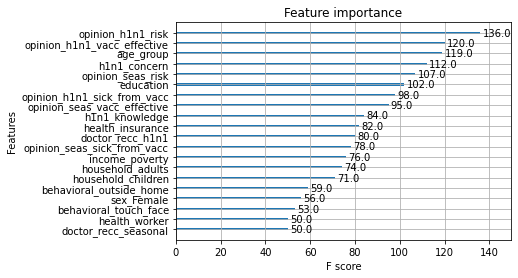

In [67]:
xgb.plot_importance(h1n1_feature_selection, max_num_features=20)
plt.show()

#### SHAP Value

In [42]:
h1n1_explainer = shap.TreeExplainer(h1n1_feature_selection)
shap_values = h1n1_explainer.shap_values(dtrain)

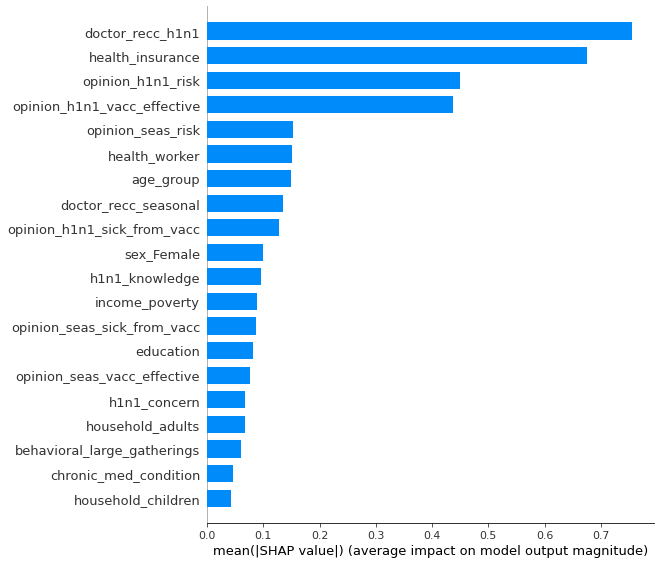

In [47]:
shap.summary_plot(shap_values,
                  plot_type="bar",
                  feature_names=X_train.columns)

#### Forward Selection

In [57]:
h1n1_forward_search = SFS(xgb.XGBClassifier(objective='binary:logistic',
                                            use_label_encoder=False,
                                            eval_metric="auc"),
                          k_features=20,
                          forward=True,
                          floating=False,
                          scoring='roc_auc',
                          cv=5,
                          verbose=0,
                          n_jobs=-1)

In [58]:
h1n1_forward_search.fit(train_transformed, label['h1n1_vaccine'])

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  enable_categorical=False,
                                                  eval_metric='auc', gamma=None,
                                                  gpu_id=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  min_child_weight=None,
                                               

In [59]:
h1n1_fsd = pd.DataFrame.from_dict(h1n1_forward_search.get_metric_dict()).T

#### Aggreate Result

In [92]:
# get top 20 column from feature importance
fi_top_20_h1n1 = list(h1n1_feature_selection.get_score().keys())[:20]

# get top 20 columns from SHAP
vals = np.abs(shap_values).mean(0)
shap_h1n1 = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name', 'feature_importance_vals'])
shap_h1n1.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_top_20_h1n1 = list(shap_h1n1['col_name'][:20].values)

# get top 20 columns from forward selection
top_20_forward_h1n1 = [i for i in h1n1_fsd.tail(1)['feature_names'].values[0]]

### seasonal_vaccine

#### Feature Importance

In [104]:
sv_feature_selection = xgb.train(parameters,
                                 dtrain_sv,
                                 num_boost_round=500,
                                 early_stopping_rounds=30,
                                 evals=[(dtrain_sv, 'train'), (dvalid_sv, 'eval')],
                                 verbose_eval=False)

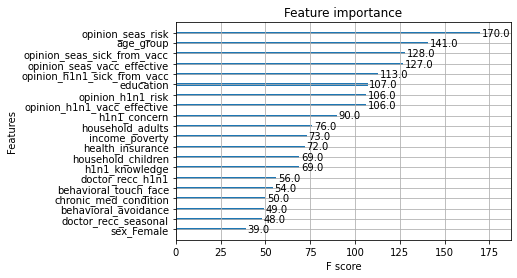

In [105]:
xgb.plot_importance(sv_feature_selection, max_num_features=20)
plt.show()

#### SHAP

In [106]:
sv_explainer = shap.TreeExplainer(sv_feature_selection)
shap_values_sv = sv_explainer.shap_values(dtrain_sv)

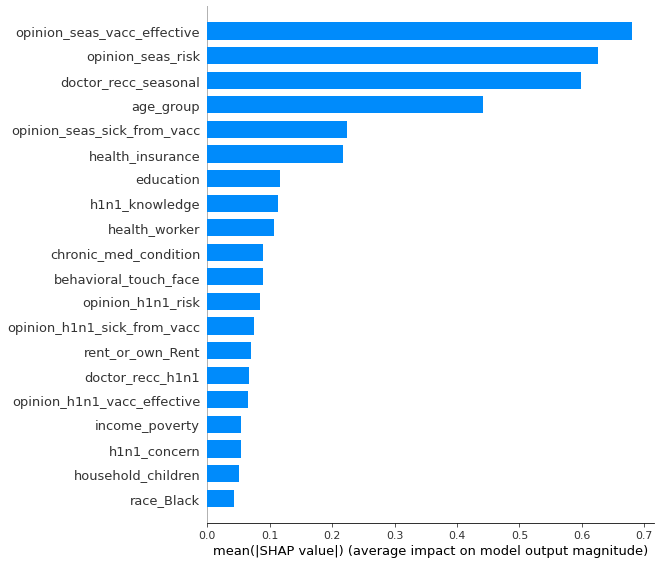

In [107]:
shap.summary_plot(shap_values_sv,
                  plot_type="bar",
                  feature_names=X_train.columns)

#### Forward Selection

In [109]:
sv_forward_search = SFS(xgb.XGBClassifier(objective='binary:logistic',
                                          use_label_encoder=False,
                                          eval_metric="auc"),
                        k_features=20,
                        forward=True,
                        floating=False,
                        scoring='roc_auc',
                        cv=5,
                        verbose=0,
                        n_jobs=-1)

In [111]:
sv_forward_search.fit(train_transformed, label['seasonal_vaccine'])

SequentialFeatureSelector(estimator=XGBClassifier(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  enable_categorical=False,
                                                  eval_metric='auc', gamma=None,
                                                  gpu_id=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  min_child_weight=None,
                                               

In [112]:
sv_fsd = pd.DataFrame.from_dict(sv_forward_search.get_metric_dict()).T

#### Aggregate Result

In [115]:
# get top 20 column from feature importance
fi_top_20_sv = list(sv_feature_selection.get_score().keys())[:20]

# get top 20 columns from SHAP
vals_sv = np.abs(shap_values_sv).mean(0)
shap_sv = pd.DataFrame(list(zip(X_train.columns, vals_sv)),
                       columns=['col_name', 'feature_importance_vals'])
shap_sv.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_top_20_sv = list(shap_sv['col_name'][:20].values)

# get top 20 columns from forward selection
top_20_forward_sv = [i for i in sv_fsd.tail(1)['feature_names'].values[0]]

## Cross Validation and Hyperparameter Selection

In [122]:
# manually assign top 20 variables to avoid running feature selection again
fi_top_20_h1n1 = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
                  'behavioral_avoidance', 'behavioral_face_mask',
                  'behavioral_wash_hands', 'behavioral_large_gatherings',
                  'behavioral_outside_home', 'behavioral_touch_face',
                  'doctor_recc_h1n1', 'doctor_recc_seasonal',
                  'chronic_med_condition', 'child_under_6_months',
                  'health_worker', 'health_insurance',
                  'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
                  'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
                  'opinion_seas_risk']

shap_top_20_h1n1 = ['doctor_recc_h1n1', 'health_insurance', 'opinion_h1n1_risk',
                    'opinion_h1n1_vacc_effective', 'opinion_seas_risk',
                    'health_worker', 'age_group', 'doctor_recc_seasonal',
                    'opinion_h1n1_sick_from_vacc', 'sex_Female',
                    'h1n1_knowledge', 'income_poverty',
                    'opinion_seas_sick_from_vacc', 'education',
                    'opinion_seas_vacc_effective', 'h1n1_concern',
                    'household_adults', 'behavioral_large_gatherings',
                    'chronic_med_condition', 'household_children']

top_20_forward_h1n1 = ['h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
                       'health_worker', 'health_insurance',
                       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
                       'opinion_seas_risk', 'race_Black', 'marital_status_NA',
                       'hhs_geo_region_bhuqouqj',
                       'employment_industry_arjwrbjb',
                       'employment_industry_haxffmxo',
                       'employment_industry_msuufmds',
                       'employment_industry_qnlwzans',
                       'employment_industry_vjjrobsf',
                       'employment_industry_wlfvacwt',
                       'employment_occupation_hfxkjkmi',
                       'employment_occupation_kldqjyjy',
                       'employment_occupation_qxajmpny']

fi_top_20_sv = ['h1n1_concern',
                'h1n1_knowledge',
                'behavioral_antiviral_meds',
                'behavioral_avoidance',
                'behavioral_face_mask',
                'behavioral_wash_hands',
                'behavioral_large_gatherings',
                'behavioral_outside_home',
                'behavioral_touch_face',
                'doctor_recc_h1n1',
                'doctor_recc_seasonal',
                'chronic_med_condition',
                'child_under_6_months',
                'health_worker',
                'health_insurance',
                'opinion_h1n1_vacc_effective',
                'opinion_h1n1_risk',
                'opinion_h1n1_sick_from_vacc',
                'opinion_seas_vacc_effective',
                'opinion_seas_risk']

shap_top_20_sv = ['opinion_seas_vacc_effective',
                  'opinion_seas_risk',
                  'doctor_recc_seasonal',
                  'age_group',
                  'opinion_seas_sick_from_vacc',
                  'health_insurance',
                  'education',
                  'h1n1_knowledge',
                  'health_worker',
                  'chronic_med_condition',
                  'behavioral_touch_face',
                  'opinion_h1n1_risk',
                  'opinion_h1n1_sick_from_vacc',
                  'rent_or_own_Rent',
                  'doctor_recc_h1n1',
                  'opinion_h1n1_vacc_effective',
                  'income_poverty',
                  'h1n1_concern',
                  'household_children',
                  'race_Black']

top_20_forward_sv = ['h1n1_knowledge',
                     'doctor_recc_h1n1',
                     'doctor_recc_seasonal',
                     'chronic_med_condition',
                     'health_worker',
                     'health_insurance',
                     'opinion_h1n1_risk',
                     'opinion_seas_vacc_effective',
                     'opinion_seas_risk',
                     'opinion_seas_sick_from_vacc',
                     'age_group',
                     'marital_status_Not Married',
                     'employment_industry_atmlpfrs',
                     'employment_industry_haxffmxo',
                     'employment_industry_wlfvacwt',
                     'employment_occupation_dcjcmpih',
                     'employment_occupation_mxkfnird',
                     'employment_occupation_qxajmpny',
                     'employment_occupation_ukymxvdu',
                     'employment_occupation_uqqtjvyb']

In [127]:
# hyperparameter for XGBoost
param_grid = {
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [10, 50, 100]
}

In [126]:
# define train data according to selected columns
fi_h1n1 = train_transformed[fi_top_20_h1n1]
shap_h1n1 = train_transformed[shap_top_20_h1n1]
forward_h1n1 = train_transformed[top_20_forward_h1n1]

fi_sv = train_transformed[fi_top_20_sv]
shap_sv = train_transformed[shap_top_20_sv]
forward_sv = train_transformed[top_20_forward_sv]

In [132]:
# define classifier
clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc",
                        use_label_encoder=False)

In [138]:
def get_cross_validation(classifier, param, train, test):
    rs = RandomizedSearchCV(classifier, param, n_iter=50,
                            n_jobs=1, verbose=0, cv=5,
                            scoring='roc_auc', random_state=42)
    rs.fit(train, label['h1n1_vaccine'])
    print_best_score_and_parameter(rs)

    return rs

#### Best hyper-parameters and ROCAUC scores

In [139]:
fi_h1n1_rs = get_cross_validation(clf, param_grid, fi_h1n1, label['h1n1_vaccine'])

Best Score: 0.8636275621340428
Best parameters: {'subsample': 1.0, 'reg_lambda': 100.0, 'n_estimators': 100, 'min_child_weight': 3.0, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4}


In [140]:
shap_h1n1_rs = get_cross_validation(clf, param_grid, shap_h1n1, label['h1n1_vaccine'])

Best Score: 0.8665085492389956
Best parameters: {'subsample': 1.0, 'reg_lambda': 100.0, 'n_estimators': 100, 'min_child_weight': 3.0, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4}


In [141]:
fs_h1n1_rs = get_cross_validation(clf, param_grid, forward_h1n1, label['h1n1_vaccine'])

Best Score: 0.8645361743253435
Best parameters: {'subsample': 0.9, 'reg_lambda': 10.0, 'n_estimators': 100, 'min_child_weight': 1.0, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 1.0, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9}


In [142]:
fi_sv_rs = get_cross_validation(clf, param_grid, fi_sv, label['seasonal_vaccine'])

Best Score: 0.8636275621340428
Best parameters: {'subsample': 1.0, 'reg_lambda': 100.0, 'n_estimators': 100, 'min_child_weight': 3.0, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4}


In [143]:
shap_sv_rs = get_cross_validation(clf, param_grid, shap_sv, label['seasonal_vaccine'])

Best Score: 0.8656752124103797
Best parameters: {'subsample': 1.0, 'reg_lambda': 100.0, 'n_estimators': 100, 'min_child_weight': 3.0, 'max_depth': 20, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4}


In [144]:
forward_sv_rs = get_cross_validation(clf, param_grid, forward_sv,
                                     label['seasonal_vaccine'])

Best Score: 0.8558200133734196
Best parameters: {'subsample': 1.0, 'reg_lambda': 50.0, 'n_estimators': 50, 'min_child_weight': 1.0, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.7}


## Prediction

In [145]:
test_transformed = transformer.transform(test_data)

In [147]:
test = pd.DataFrame(test_transformed,
                    columns=list(numerical.values) + ordinal + list(one_hot_encoder_feature_names),
                    index=test_data.index)

In [149]:
h1n1_test = test[shap_top_20_h1n1]
sv_test = test[shap_top_20_sv]

In [152]:
h1n1_predict = shap_h1n1_rs.predict_proba(h1n1_test)
sv_predict = shap_sv_rs.predict_proba(sv_test)

In [155]:
h1n1_submission = h1n1_predict[:,1].reshape(-1,1)
sv_submission = sv_predict[:,1].reshape(-1,1)

## Submission

In [156]:
submission = pd.read_csv('submission_format.csv')
submission.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.5,0.7
1,26708,0.5,0.7
2,26709,0.5,0.7
3,26710,0.5,0.7
4,26711,0.5,0.7


In [157]:
submission['h1n1_vaccine'] = h1n1_submission
submission['seasonal_vaccine'] = sv_submission

In [158]:
submission.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.145791,0.162188
1,26708,0.031792,0.040185
2,26709,0.184144,0.236494
3,26710,0.634631,0.629811
4,26711,0.416499,0.232808


In [160]:
submission.to_csv('submission.csv', index=False)